<img align=left src="CRIkit_Logo.png"> 
<br>
<br>
<br>
<br>
<br>
#####Coherent Raman Imaging toolKit

# A Quick and Simple Demonstration


###Setup

In [7]:
# Setup our imports
import sys
import time
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt

from matplotlib.figure import Figure

from openpyxl import Workbook
from openpyxl import load_workbook
import als_methods as als
import pre as crikit

In [9]:
def nm2wavenumber(pump, antistokes):
    return 10**7*(1/np.array(antistokes) - 1/pump)

def area(x):
    return np.sum(x)

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

In [198]:
W = load_workbook('data_processing.xlsx')
p = W.get_sheet_by_name(name = 'Sheet1')

a=[]

for row in p.iter_rows():
    for k in row:
        a.append(k.internal_value)


/Users/fuli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  


In [230]:
dataNumer = 0

## used to 2th part range
min_wavelength = 2150
max_wavelength = 4001

## used to 1th part range
#min_wavelength = 1
#max_wavelength = 901

for i in a:
    if  (not is_number(i)):
        dataNumer  = dataNumer + 1
    elif is_number(i):
        break
print("dataNumer is: ", dataNumer)

data = np.resize(a, [int(len(a)/dataNumer), dataNumer])
# del a
dataNameList = data[0,:]
print("The dictionary name list is:\n", dataNameList)

##   -----------    reshape the data to dictionary, 
##   and normalized the data which makes the area of each plot to unit 1;
dic ={}
for i in range(dataNumer):
    dic[dataNameList[i]] = data[min_wavelength:max_wavelength,i].astype(np.float)

dic_norm = {}  ## nornalized data dictionary, not included the 0 index which is the wavelength
for i in dataNameList[1:]:
    #print(i)
    dic_norm[i] = dic[i]/area(dic[i])

dic_norm["wavenumber"] = nm2wavenumber(1064, dic[dataNameList[0]])
dic_norm[dataNameList[0]] = dic[dataNameList[0]]

dic["wavenumber"] = dic_norm["wavenumber"]


dataNumer is:  10
The dictionary name list is:
 ['wavelenth' 'background' 'olive oil' 'peril oil' 'immersion oil'
 'fiber sample' 'plastic bg' 'ND 1' 'ND 2' 'ND 3']


<IPython.core.display.Javascript object>


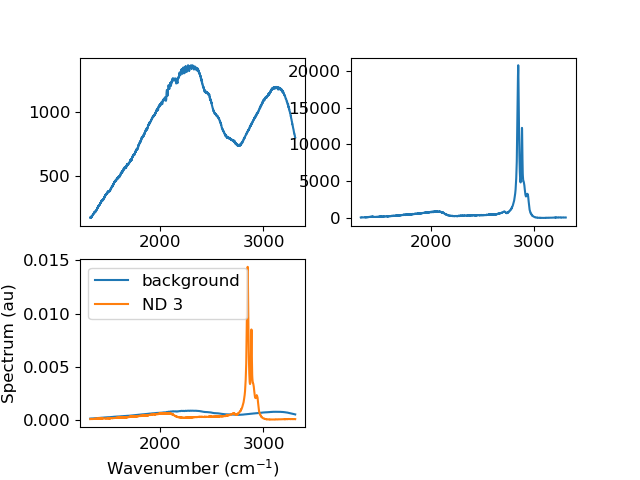

In [231]:
%matplotlib notebook

WN = dic["wavenumber"]  

matter = 'ND 3'

#WN = dic["wavelenth"]

plt.subplot(221)
plt.plot(WN, dic["background"], label = 'background')


plt.subplot(222)
plt.plot(WN, dic[matter], label = matter)

plt.subplot(223)
plt.plot(WN, dic_norm["background"], label = 'background')

plt.plot(WN, dic_norm[matter], label = matter)



plt.legend()
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Spectrum (au)')
plt.show()


<IPython.core.display.Javascript object>


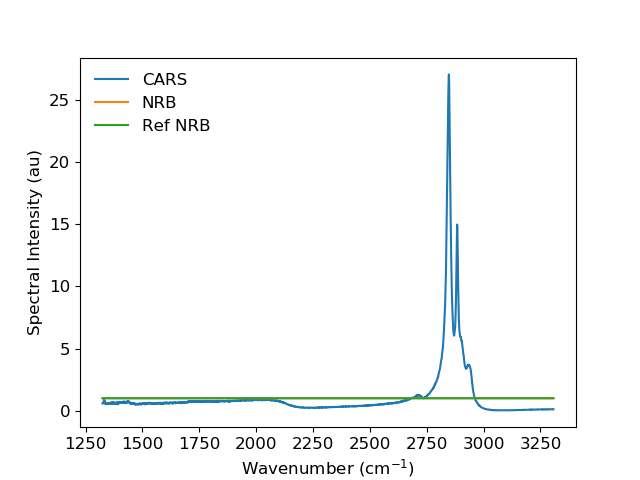

In [232]:
%matplotlib notebook

I_CARS = dic_norm[matter]/dic_norm["background"]
I_NRB = np.zeros(len(dic_norm[matter])) +1
I_REF = np.zeros(len(dic_norm[matter])) +1

plt.rc('font',size=12)
plt.plot(WN, I_CARS, label = 'CARS')
plt.plot(WN, I_NRB, label = 'NRB')
plt.plot(WN, I_REF, label = 'Ref NRB')

plt.legend(loc=0,frameon = False)
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Spectral Intensity (au)')
plt.show()

###Simulate a CARS Signal

In this extremely simplied example:<br>
<ul>
<li>$I_{CARS}(\omega) = \left | \chi_R(\omega) + \chi_{NR}(\omega) \right |^2$
<li>$I_{NRB}(\omega) = \left | \chi_{NR}(\omega) \right |^2$
<li>$I_{REF}(\omega) = \left | \chi_{REF}(\omega) \right |^2$
</ul>

The NRB is the **actual** background and the **reference [NRB]** is a close-but-not-the-same measurement.

### Perform the Kramers-Kronig Relation to Extract the Spectral Phase

####References:

Y. Liu, Y. J. Lee, and M. T. Cicerone, "Broadband CARS spectral phase retrieval using a time-domain Kramers-Kronig transform," Opt. Lett. 34, 1363-1365 (2009).

C. H. Camp Jr, Y. J. Lee, and M. T. Cicerone, "Quantitative, comparable coherent anti-Stokes Raman scattering (CARS) spectroscopy: Correcting errors in phase retrieval" (2015). arXiv:1507.06543.


<IPython.core.display.Javascript object>


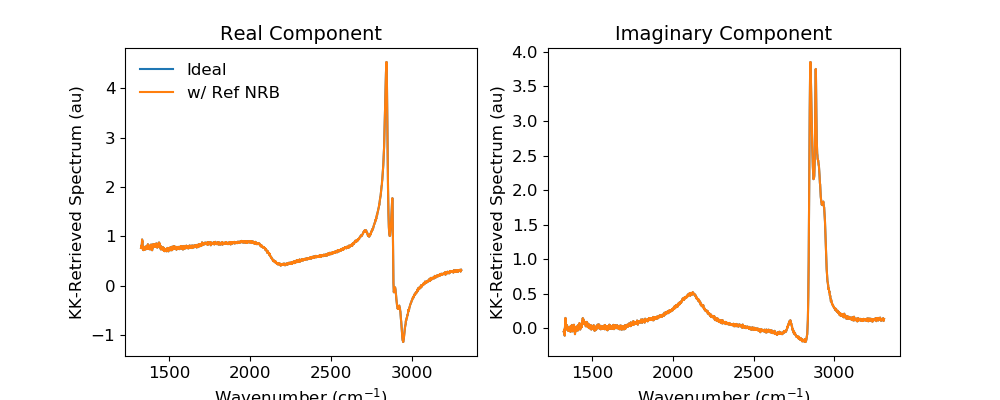

In [233]:
%matplotlib notebook

PHASE_OFFSET = 0 # DC phase-offset (default = 0)
NORM_BY_NRB = 1 # Normalize retrieved spectrum by NRB/REF-- Removes the optical system response (default = 1)


# Perform the Kramers-Kronig Relationship when the NRB is known (ideal case)
Retrieved_complex_spectrum_ideal = crikit.kkrelation(I_NRB,I_CARS,PHASE_OFFSET,NORM_BY_NRB) # Complex spectrum
Retrieved_Raman_spectrum_ideal = Retrieved_complex_spectrum_ideal.imag # "Raman-like# (imag{complex spectrum})

# Perform the Kramers-Kronig Relationship when using a surrogate NRB "reference"
Retrieved_complex_spectrum_w_reference = crikit.kkrelation(I_REF,I_CARS,PHASE_OFFSET,NORM_BY_NRB) # Complex spectrum
Retrieved_Raman_spectrum_w_reference = Retrieved_complex_spectrum_w_reference.imag # "Raman-like# (imag{complex spectrum})

Retrieved_complex_spectrum_w_reference.imag = -Retrieved_complex_spectrum_w_reference.imag;
Retrieved_complex_spectrum_ideal.imag = -Retrieved_complex_spectrum_ideal.imag

plt.figure(figsize=[10, 4])
plt.subplot(121)

plt.plot(WN, Retrieved_complex_spectrum_ideal.real, label = 'Ideal')
plt.plot(WN, Retrieved_complex_spectrum_w_reference.real, label = 'w/ Ref NRB')

plt.legend(loc=0,frameon = False)
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('KK-Retrieved Spectrum (au)')
plt.title('Real Component', fontsize=14)

plt.subplot(122)
plt.plot(WN, Retrieved_complex_spectrum_ideal.imag, label = 'Ideal (Imag)')
plt.plot(WN, Retrieved_complex_spectrum_w_reference.imag, label = 'w/ Ref NRB (Imag)')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('KK-Retrieved Spectrum (au)')
plt.title('Imaginary Component', fontsize=14)
plt.show()

### Phase-Detrending Using Asymmetric Least Square (ALS)

<IPython.core.display.Javascript object>


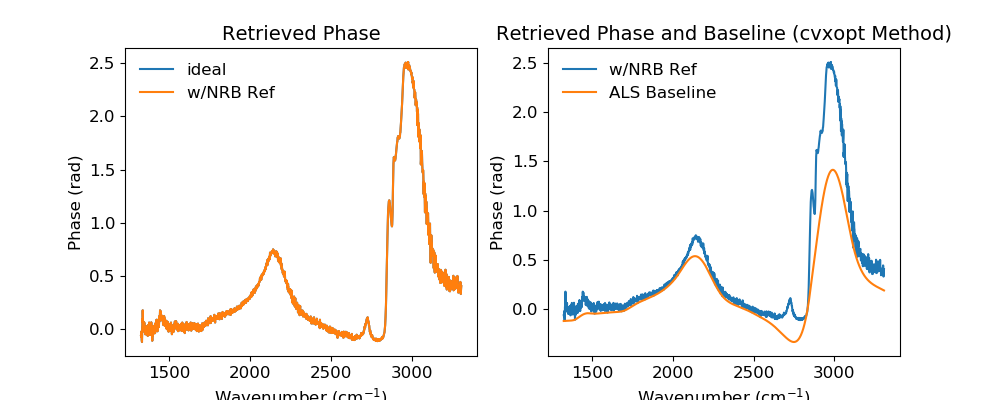

In [234]:
# ALS takes two parameters-- their ratio is the most important
SMOOTHNESS_PARAM = 1e3
ASYM_PARAM = 1e-4

plt.figure(figsize=[10, 4])
plt.rc('font',size=12)

plt.subplot(121)
plt.plot(WN, np.angle(Retrieved_complex_spectrum_ideal),label = 'ideal')
plt.plot(WN, np.angle(Retrieved_complex_spectrum_w_reference), label = 'w/NRB Ref')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Phase (rad)')
plt.title('Retrieved Phase', fontsize = 14)
plt.legend(loc = 0, frameon = False)

# Find baseline with optimal als method (see CRIkit.utils.als_methods for more info)
[Baseline, als_method] = als.als_baseline(np.angle(Retrieved_complex_spectrum_w_reference), SMOOTHNESS_PARAM, \
                                             ASYM_PARAM)
plt.subplot(122)
plt.plot(WN, np.angle(Retrieved_complex_spectrum_w_reference), label = 'w/NRB Ref')
plt.plot(WN, Baseline, label = 'ALS Baseline')

plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Phase (rad)')
plt.title('Retrieved Phase and Baseline (' + als_method + ' Method)', fontsize = 14)
plt.legend(frameon = False)
plt.show()

###Correcting for Phase and Amplitude Error

<IPython.core.display.Javascript object>


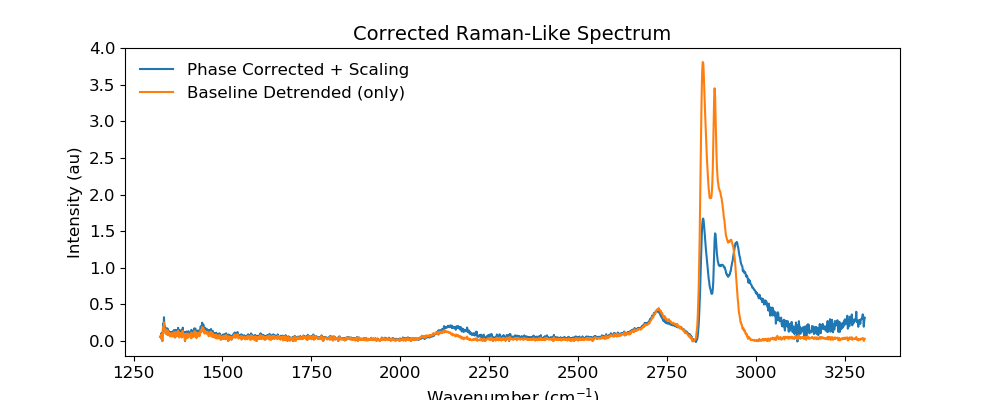

In [235]:
# Error phase (baseline) and amplitude connected via Kramers-Kronig relation (Hilbert transform)
Error_phase = Baseline
Error_amp = np.exp(crikit.hilbertfft(Error_phase).imag)
Correction_factor_1 = 1/Error_amp * np.exp(-1j*Error_phase)

Phase_Corrected = Retrieved_complex_spectrum_w_reference*Correction_factor_1

# Amiguity in phase-amp correction found by looking at mean-trend line of real componenet
# Using low-order, large-window Savitky-Golay
SGOLAY_WINDOW = 601
SGOLAY_POLY_ORDER = 2

Scaling_factor = 1/(scipy.signal.savgol_filter(np.real(Phase_Corrected),SGOLAY_WINDOW,SGOLAY_POLY_ORDER,axis=0))

Corrected = Scaling_factor*Phase_Corrected

# Compare these results with traditional baseline detrending of the Raman-like spectrum retrieved
# directly from the Kramers-Kronig relation
Just_amplitude_corrected = Retrieved_Raman_spectrum_w_reference - als.als_baseline(Retrieved_Raman_spectrum_w_reference,1e3,1e-4)[0]

plt.figure(figsize=[10, 4])
plt.rc('font',size=12)
plt.plot(WN,Corrected.imag, label='Phase Corrected + Scaling')
plt.plot(WN,Just_amplitude_corrected, label = 'Baseline Detrended (only)')
#plt.plot(WN,CHI_R.imag/np.abs(CHI_NR), 'r--', label = 'Ideal')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Corrected Raman-Like Spectrum', fontsize = 14)
plt.legend(frameon = False)

##Phase Detrending and Scaling (i.e., Full Correction) in 3 line

<IPython.core.display.Javascript object>


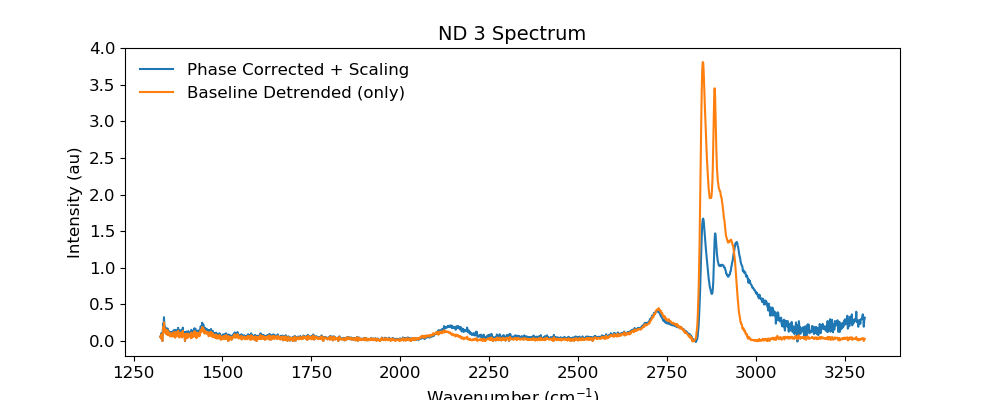

In [236]:
"""
These are defined earlier:
SMOOTHNESS_PARAM
ASYM_PARAM
SGOLAY_WINDOW
SGOLAY_POLY_ORDER
"""
# Starts here
Error_phase = als.als_baseline(np.angle(Retrieved_complex_spectrum_w_reference), SMOOTHNESS_PARAM,ASYM_PARAM)[0]
Phase_Corrected = Retrieved_complex_spectrum_w_reference*(1/np.exp(crikit.hilbertfft(Error_phase).imag) * \
                                                          np.exp(-1j*Error_phase))
Corrected = 1/(scipy.signal.savgol_filter(np.real(Phase_Corrected),601,2,axis=0))*Phase_Corrected
# Done

Just_amplitude_corrected = Retrieved_Raman_spectrum_w_reference - \
    als.als_baseline(Retrieved_Raman_spectrum_w_reference,1e3,1e-4)[0]

plt.figure(figsize=[10, 4])
plt.rc('font',size=12)
plt.plot(WN,Corrected.imag, label='Phase Corrected + Scaling')
plt.plot(WN,Just_amplitude_corrected, label = 'Baseline Detrended (only)')
#plt.plot(WN,CHI_R.imag/np.abs(CHI_NR), 'r--', label = 'Ideal')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title(matter + ' Spectrum', fontsize = 14)
plt.legend(frameon = False)

In [237]:
result = np.vstack((WN,Just_amplitude_corrected, Corrected.imag)).T
np.savetxt(matter+"_2.txt", result)

<IPython.core.display.Javascript object>


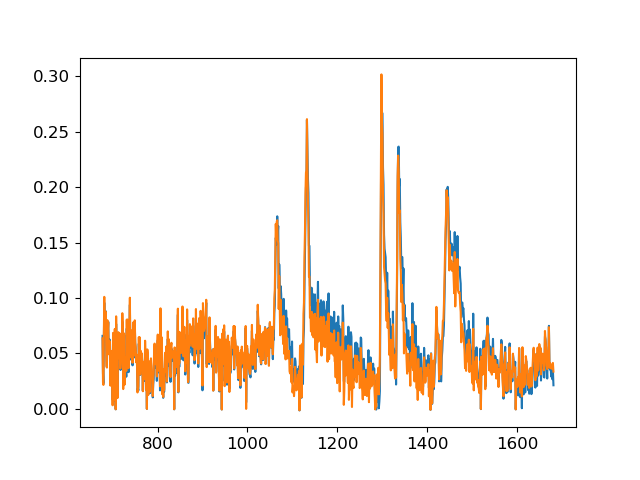

In [207]:
%matplotlib notebook

plt.plot(result[:,0],result[:,1], label='Phase Corrected + Scaling')
plt.plot(result[:,0],result[:,2], label='Phase Corrected + Scaling')

plt.show()